# Gesture to Text: AI-Powered Sign Language Interpretation

## Checkpoint - 1

### Importing all the required libraries

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision
from torch import nn
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import random
import os
import shutil
import zipfile
import os
import random
import torch.nn as nn
import torch.nn.functional as F

### Extracting the dataset from the zip file

In [2]:
zip_path = '/archive.zip'
extract_path = '/dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

### Checking if there is any duplication in data while extracting

In [3]:
data_dir = '/dataset'

for subdir in os.listdir(data_dir):
    subdir_path = os.path.join(data_dir, subdir)
    if os.path.isdir(subdir_path):
        print(f"Contents of {subdir_path}: {os.listdir(subdir_path)}")
    else:
        print(f"Skipping non-directory file: {subdir_path}")

Contents of /dataset/archive: ['asl_alphabet_train', 'asl_alphabet_test']


### Defining the transformer in order to pre-process the training data

In [4]:
data_dir = '/dataset'
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder('/dataset/archive/asl_alphabet_train/asl_alphabet_train', transform=transform)

print(f"Total images in all the classes: {len(dataset)}")
print(f"Number of classes in all: {len(dataset.classes)}")
print(f"Number of images in every class: {[len([x for x in dataset.targets if x == i]) for i in range(len(dataset.classes))]}")

Total images in all the classes: 27099
Number of classes in all: 29
Number of images in every class: [2289, 1947, 1731, 1497, 813, 687, 543, 597, 1566, 615, 660, 597, 906, 642, 435, 723, 615, 795, 750, 880, 899, 579, 1065, 1137, 1092, 903, 615, 1005, 516]


### Spliting the data into training data and validation data

In [5]:
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

In [6]:
# Split the dataset into training and testing sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [7]:
# Get the number of samples in each set
num_train_samples = len(train_dataset)
num_val_samples = len(val_dataset)

print(f'Number of training samples: {num_train_samples}')
print(f'Number of testing samples: {num_val_samples}')

Number of training samples: 21679
Number of testing samples: 5420


In [8]:
num_classes = len(dataset.classes)
num_classes

29

### Loading the training and validation data using DataLoaders

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Checking the dimension of input data sent for training

In [ ]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

for images, labels in val_loader:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 200, 200]) torch.Size([32])
torch.Size([32, 3, 200, 200]) torch.Size([32])


### Visualizing some images in order to check how are the training data which will be used for model training

In [ ]:
def show_random_samples(dataset, class_names, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i in range(num_samples):
        random_idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[random_idx]
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C) for displaying
        axes[i].imshow(img)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')
    plt.show()

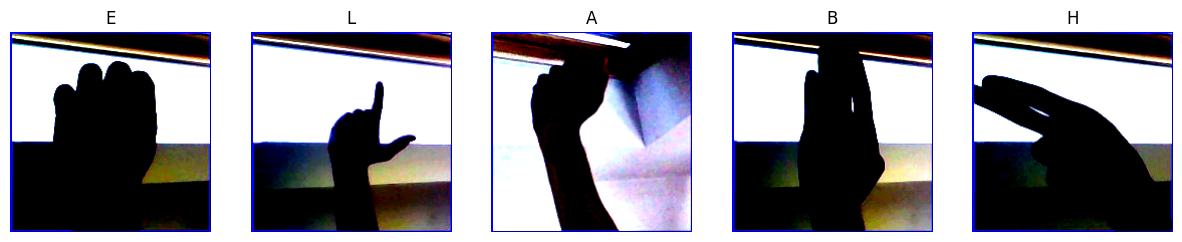

In [ ]:
class_names = dataset.classes
show_random_samples(train_dataset, class_names)

### Model Architecture for Simple CNN Model

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=29):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.fc1 = nn.Linear(128 * 23 * 23, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor dynamically
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 29
my_model = SimpleCNN(num_classes=num_classes).to(device)

my_model_criterion = nn.CrossEntropyLoss()
my_model_optimizer = optim.Adam(my_model.parameters(), lr=0.001)

summary(my_model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
         MaxPool2d-2           [-1, 32, 99, 99]               0
            Conv2d-3           [-1, 64, 97, 97]          18,496
         MaxPool2d-4           [-1, 64, 48, 48]               0
            Conv2d-5          [-1, 128, 46, 46]          73,856
         MaxPool2d-6          [-1, 128, 23, 23]               0
            Linear-7                  [-1, 512]      34,669,056
           Dropout-8                  [-1, 512]               0
            Linear-9                   [-1, 29]          14,877
Total params: 34,777,181
Trainable params: 34,777,181
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 20.27
Params size (MB): 132.66
Estimated Total Size (MB): 153.40
--------------------------------

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Training function
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch in tqdm(iterator, desc="Training"):
        optimizer.zero_grad()
        images, labels = batch[0].to(device), batch[1].to(device)
        predictions = model(images)
        loss = criterion(predictions, labels)
        acc = accuracy(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Validation function
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for batch in tqdm(iterator, desc="Validation"):
            images, labels = batch[0].to(device), batch[1].to(device)
            predictions = model(images)
            loss = criterion(predictions, labels)
            acc = accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Initialize lists to store training and validation scores
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Define number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    train_loss, train_acc = train(my_model, train_loader, my_model_optimizer, my_model_criterion)
    val_loss, val_acc = evaluate(my_model, val_loader, my_model_criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


Validation: 100%|██████████| 170/170 [00:10<00:00, 16.58it/s]


Epoch: 01, Train Loss: 0.7978, Train Acc: 0.7593, Val Loss: 0.1061, Val Acc: 0.9688


Validation: 100%|██████████| 170/170 [00:10<00:00, 16.22it/s]


Epoch: 02, Train Loss: 0.1344, Train Acc: 0.9563, Val Loss: 0.0322, Val Acc: 0.9901


Validation: 100%|██████████| 170/170 [00:10<00:00, 16.39it/s]


Epoch: 03, Train Loss: 0.0789, Train Acc: 0.9767, Val Loss: 0.0239, Val Acc: 0.9950


Validation: 100%|██████████| 170/170 [00:10<00:00, 16.62it/s]


Epoch: 04, Train Loss: 0.0586, Train Acc: 0.9811, Val Loss: 0.0314, Val Acc: 0.9923


Validation: 100%|██████████| 170/170 [00:08<00:00, 19.08it/s]


Epoch: 05, Train Loss: 0.0493, Train Acc: 0.9852, Val Loss: 0.0148, Val Acc: 0.9965


Validation: 100%|██████████| 170/170 [00:09<00:00, 17.84it/s]


Epoch: 06, Train Loss: 0.0384, Train Acc: 0.9885, Val Loss: 0.0303, Val Acc: 0.9928


Validation: 100%|██████████| 170/170 [00:08<00:00, 19.42it/s]


Epoch: 07, Train Loss: 0.0411, Train Acc: 0.9876, Val Loss: 0.0155, Val Acc: 0.9954


Validation: 100%|██████████| 170/170 [00:09<00:00, 17.73it/s]


Epoch: 08, Train Loss: 0.0260, Train Acc: 0.9919, Val Loss: 0.0148, Val Acc: 0.9963


Validation: 100%|██████████| 170/170 [00:10<00:00, 16.40it/s]


Epoch: 09, Train Loss: 0.0260, Train Acc: 0.9933, Val Loss: 0.0349, Val Acc: 0.9939


Validation: 100%|██████████| 170/170 [00:10<00:00, 16.47it/s]

Epoch: 10, Train Loss: 0.0211, Train Acc: 0.9935, Val Loss: 0.0126, Val Acc: 0.9961


### Model Architecture : ResNet Model

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=29):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def ResNet18(num_classes=29):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)


### Loading the model on gpu and defining the optimizer for the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet18_model = ResNet18(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_model.parameters(), lr=0.001)

summary(resnet18_model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,408
       BatchNorm2d-2         [-1, 64, 100, 100]             128
              ReLU-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]          36,864
       BatchNorm2d-6           [-1, 64, 50, 50]             128
              ReLU-7           [-1, 64, 50, 50]               0
            Conv2d-8           [-1, 64, 50, 50]          36,864
       BatchNorm2d-9           [-1, 64, 50, 50]             128
             ReLU-10           [-1, 64, 50, 50]               0
       BasicBlock-11           [-1, 64, 50, 50]               0
           Conv2d-12           [-1, 64, 50, 50]          36,864
      BatchNorm2d-13           [-1, 64, 50, 50]             128
             ReLU-14           [-1, 64,

### Training the model : Iterating over the training data to optimize the model weights using backpropagation, evaluating performance on validation data, recording training and validation metrics.

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    resnet18_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet18_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}")

    resnet18_model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18_model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_val_loss / len(val_loader.dataset)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print()

print("Training complete!")

torch.save(resnet18_model.state_dict(), 'resnet18_model.pth')
print("Model saved!")

Epoch 1/10
----------
Training Loss: 0.5927, Training Accuracy: 0.8249
Validation Loss: 0.1081, Validation Accuracy: 0.9648

Epoch 2/10
----------
Training Loss: 0.0381, Training Accuracy: 0.9905
Validation Loss: 0.0848, Validation Accuracy: 0.9718

Epoch 3/10
----------
Training Loss: 0.0352, Training Accuracy: 0.9900
Validation Loss: 0.0319, Validation Accuracy: 0.9902

Epoch 4/10
----------
Training Loss: 0.0249, Training Accuracy: 0.9936
Validation Loss: 0.0006, Validation Accuracy: 0.9998

Epoch 5/10
----------
Training Loss: 0.0369, Training Accuracy: 0.9889
Validation Loss: 0.0156, Validation Accuracy: 0.9958

Epoch 6/10
----------
Training Loss: 0.0059, Training Accuracy: 0.9983
Validation Loss: 0.0001, Validation Accuracy: 1.0000

Epoch 7/10
----------
Training Loss: 0.0003, Training Accuracy: 1.0000
Validation Loss: 0.0000, Validation Accuracy: 1.0000

Epoch 8/10
----------
Training Loss: 0.0272, Training Accuracy: 0.9921
Validation Loss: 2.2729, Validation Accuracy: 0.6087



### Plotting Training Loss against Validation Loss

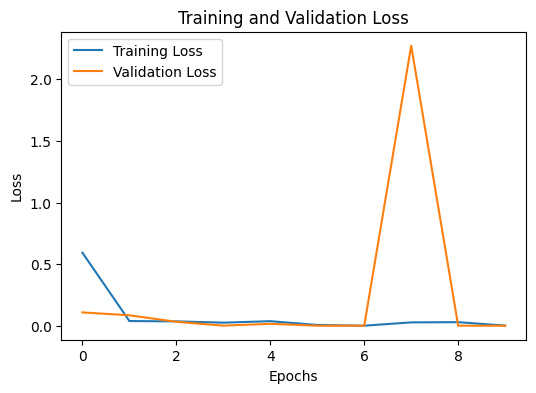

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### PLotting Training accuracy against Validation accuracy

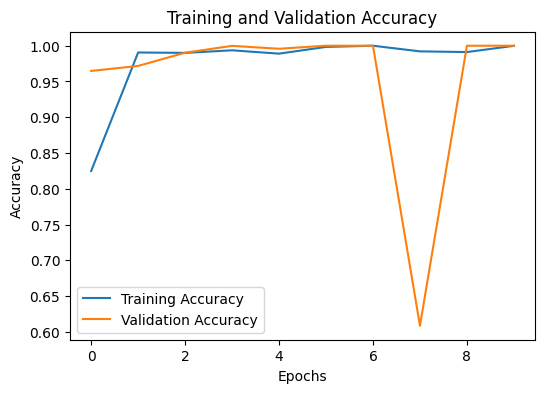

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

## Testing the model on test data

### Defining Transformer for the testing data

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
class ASLTestDataset(Dataset):
    def __init__(self, test_data_dir, transform=None):
        self.test_data_dir = test_data_dir
        self.transform = transform
        self.images = os.listdir(test_data_dir)
        self.class_names = sorted(set(img.split('_')[0] for img in self.images))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.class_names)}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.test_data_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label = self.class_to_idx[img_name.split('_')[0]]

        if self.transform:
            image = self.transform(image)

        return image, label

### Loading the test data using DataLoader

In [ ]:
test_data_dir = '/dataset/archive/asl_alphabet_test/asl_alphabet_test'

test_dataset = ASLTestDataset(test_data_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

### Loading the trained model in order to test on testing data

In [ ]:
num_classes = 29
resnet18_model = ResNet18(num_classes=num_classes).to(device)
resnet18_model.load_state_dict(torch.load('resnet18_model.pth'))
resnet18_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Testing the model

In [ ]:
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet18_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9286


### Visualizing the predictions made by the model

In [ ]:
def show_test_predictions(images, labels, predictions, class_names, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i in range(num_samples):
        random_idx = random.randint(0, len(images) - 1)
        img = images[random_idx].permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.clamp(0, 1)
        axes[i].imshow(img)
        axes[i].set_title(f"True: {class_names[labels[random_idx]]}\nPred: {class_names[predictions[random_idx]]}")
        axes[i].axis('off')
    plt.show()

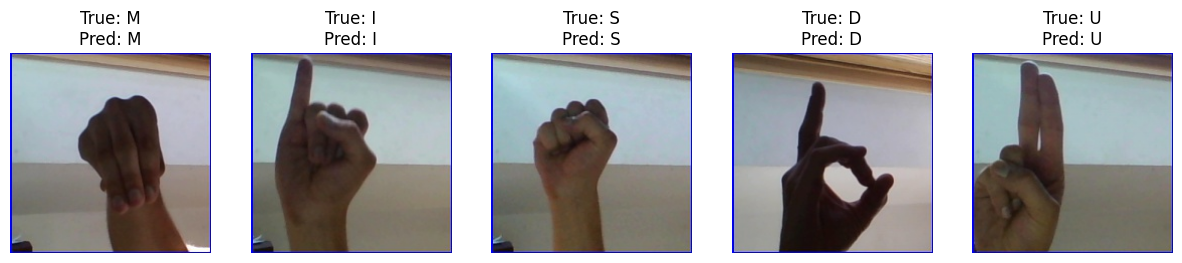

Testing complete!


In [ ]:
test_images, test_labels = next(iter(test_loader))
test_predictions = [all_predictions[i] for i in range(len(test_images))]
show_test_predictions(test_images, test_labels, test_predictions, test_dataset.class_names)

print("Testing complete!")

### Model Architecture : VGG Net

In [ ]:
# Define transformations for VGGNet
transform_vgg = transforms.Compose([
    transforms.Resize((224, 224)),  # VGGNet requires 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset with the transformation for VGGNet
dataset_vgg = datasets.ImageFolder(data_dir, transform=transform_vgg)

print(f"Total images in all the classes: {len(dataset)}")
print(f"Number of classes in all: {len(dataset.classes)}")
print(f"Number of images in every class: {[len([x for x in dataset.targets if x == i]) for i in range(len(dataset.classes))]}")
# Split dataset
train_ratio = 0.8
train_size_vgg = int(train_ratio * len(dataset_vgg))
val_size_vgg = len(dataset_vgg) - train_size_vgg
train_dataset_vgg, val_dataset_vgg = random_split(dataset_vgg, [train_size_vgg, val_size_vgg])

# Create data loaders
train_loader_vgg = DataLoader(train_dataset_vgg, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader_vgg = DataLoader(val_dataset_vgg, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

Total images in all the classes: 27099
Number of classes in all: 29
Number of images in every class: [2289, 1947, 1731, 1497, 813, 687, 543, 597, 1566, 615, 660, 597, 906, 642, 435, 723, 615, 795, 750, 880, 899, 579, 1065, 1137, 1092, 903, 615, 1005, 516]


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=29):  # Assuming 29 classes for ASL alphabet
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [ ]:
num_classes = len(dataset_vgg.classes)
model_vgg = VGGNet(num_classes=num_classes)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_vgg.to(device)

VGGNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model_vgg.train()
    running_loss = 0.0
    for images, labels in train_loader_vgg:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model_vgg(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    model_vgg.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader_vgg:
            images, labels = images.to(device), labels.to(device)
            outputs = model_vgg(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

torch.save(model_vgg.state_dict(), 'vgg_sign_language_model.pth')

print("Training and validation completed.")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/10], Loss: 0.0000
Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch [2/10], Loss: 0.0000
Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch [3/10], Loss: 0.0000
Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch [4/10], Loss: 0.0000
Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch [5/10], Loss: 0.0000
Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch [6/10], Loss: 0.0000
Validation Loss: 0.0000, Validation Accuracy: 100.00%


### Model Architecture : GoogleNet Model

In [ ]:
class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()
        self.branch1 = nn.Conv2d(in_channels, ch1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.BatchNorm2d(ch3x3red),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ch3x3),
            nn.ReLU(inplace=True)
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.BatchNorm2d(ch5x5red),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(ch5x5),
            nn.ReLU(inplace=True)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)
class GoogleNet(nn.Module):
    def _init_(self, num_classes=29):
        super(GoogleNet, self)._init_()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(192)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)  # Increase dropout to 0.5
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GoogleNet(num_classes=29).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
         MaxPool2d-2           [-1, 64, 56, 56]               0
            Conv2d-3           [-1, 64, 56, 56]           4,160
            Conv2d-4          [-1, 192, 56, 56]         110,784
         MaxPool2d-5          [-1, 192, 28, 28]               0
            Conv2d-6           [-1, 64, 28, 28]          12,352
            Conv2d-7           [-1, 96, 28, 28]          18,528
            Conv2d-8          [-1, 128, 28, 28]         110,720
            Conv2d-9           [-1, 16, 28, 28]           3,088
           Conv2d-10           [-1, 32, 28, 28]          12,832
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 32, 28, 28]           6,176
        Inception-13          [-1, 256, 28, 28]               0
           Conv2d-14          [-1, 128,

In [ ]:
from torch.optim import lr_scheduler

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10
patience = 7
early_stopping = EarlyStopping(patience=patience, verbose=True)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in tqdm(train_loader, desc='Training'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_loss / len(val_loader.dataset)
    epoch_val_accuracy = correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_accuracy:.4f}')
    print(f'Validation Loss: {epoch_val_loss:.4f} Acc: {epoch_val_accuracy:.4f}')


    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)
    early_stopping(epoch_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

model.load_state_dict(torch.load('checkpoint.pt'))

Epoch 1/10
----------


Validation: 100%|██████████| 170/170 [00:09<00:00, 18.09it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Train Loss: 0.0126 Acc: 0.9961
Validation Loss: 0.0016 Acc: 0.9994
Validation loss decreased (inf --> 0.001556).  Saving model ...
Epoch 2/10
----------


Validation: 100%|██████████| 170/170 [00:10<00:00, 16.29it/s]


Train Loss: 0.0200 Acc: 0.9933
Validation Loss: 0.0037 Acc: 0.9989
EarlyStopping counter: 1 out of 7
Epoch 3/10
----------


Validation: 100%|██████████| 170/170 [00:10<00:00, 16.26it/s]


Train Loss: 0.0192 Acc: 0.9946
Validation Loss: 0.0265 Acc: 0.9911
EarlyStopping counter: 2 out of 7
Epoch 4/10
----------


Validation: 100%|██████████| 170/170 [00:10<00:00, 16.89it/s]


Train Loss: 0.0073 Acc: 0.9980
Validation Loss: 0.0102 Acc: 0.9982
EarlyStopping counter: 3 out of 7
Epoch 5/10
----------


Validation: 100%|██████████| 170/170 [00:08<00:00, 18.89it/s]


Train Loss: 0.0179 Acc: 0.9950
Validation Loss: 0.0024 Acc: 0.9991
EarlyStopping counter: 4 out of 7
Epoch 6/10
----------


Validation: 100%|██████████| 170/170 [00:11<00:00, 15.02it/s]


Train Loss: 0.0133 Acc: 0.9959
Validation Loss: 0.0188 Acc: 0.9946
EarlyStopping counter: 5 out of 7
Epoch 7/10
----------


Validation: 100%|██████████| 170/170 [00:10<00:00, 15.52it/s]


Train Loss: 0.0137 Acc: 0.9959
Validation Loss: 0.0001 Acc: 1.0000
Validation loss decreased (0.001556 --> 0.000118).  Saving model ...
Epoch 8/10
----------


Validation: 100%|██████████| 170/170 [00:08<00:00, 19.51it/s]


Train Loss: 0.0190 Acc: 0.9946
Validation Loss: 0.0001 Acc: 1.0000
Validation loss decreased (0.000118 --> 0.000109).  Saving model ...
Epoch 9/10
----------


Validation: 100%|██████████| 170/170 [00:09<00:00, 17.05it/s]


Train Loss: 0.0064 Acc: 0.9982
Validation Loss: 0.0071 Acc: 0.9972
EarlyStopping counter: 1 out of 7
Epoch 10/10
----------


Validation: 100%|██████████| 170/170 [00:10<00:00, 16.44it/s]


Train Loss: 0.0149 Acc: 0.9963
Validation Loss: 0.0193 Acc: 0.9948
EarlyStopping counter: 2 out of 7


<All keys matched successfully>

### Model Architecture : MobileNet Model

In [ ]:
transform_mobnet = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for MobileNetV2
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset_mobnet = datasets.ImageFolder(data_dir, transform=transform_mobnet)

print(f"Total images in all the classes: {len(dataset_mobnet)}")
print(f"Number of classes in all: {len(dataset_mobnet.classes)}")
print(f"Number of images in every class: {[len([x for x in dataset_mobnet.targets if x == i]) for i in range(len(dataset_mobnet.classes))]}")

train_ratio = 0.8
train_size_mobnet = int(train_ratio * len(dataset_mobnet))
val_size_mobnet = len(dataset_mobnet) - train_size_mobnet
train_dataset_mobnet, val_dataset_mobnet = random_split(dataset_mobnet, [train_size_mobnet, val_size_mobnet])

num_train_samples = len(train_dataset_mobnet)
num_val_samples = len(val_dataset_mobnet)

print(f'Number of training samples: {num_train_samples}')
print(f'Number of testing samples: {num_val_samples}')

train_loader_mobnet = DataLoader(train_dataset_mobnet, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader_mobnet = DataLoader(val_dataset_mobnet, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

Total images in all the classes: 27127
Number of classes in all: 1
Number of images in every class: [27127]
Number of training samples: 21701
Number of testing samples: 5426


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class ConvBNReLU(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.ReLU6(inplace=True)
        )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNReLU(inp, inp * expand_ratio, kernel_size=1))
        layers.extend([
            ConvBNReLU(inp * expand_ratio, inp * expand_ratio, stride=stride, groups=inp * expand_ratio),
            nn.Conv2d(inp * expand_ratio, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=29, width_mult=1.0):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280

        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        input_channel = int(input_channel * width_mult)
        self.last_channel = int(last_channel * max(1.0, width_mult))
        features = [ConvBNReLU(3, input_channel, stride=2)]
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1))
        self.features = nn.Sequential(*features)

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])
        x = self.classifier(x)
        return x


In [ ]:
num_classes = 29 
model = MobileNetV2(num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Validation Accuracy: {100 * correct / total}%")

torch.save(model.state_dict(), 'mobilenet_v2_custom.pth')


Epoch 1/10, Loss: 0.6614028779998598
Validation Accuracy: 97.06642066420665%
Epoch 2/10, Loss: 0.07482107187371294
Validation Accuracy: 98.78228782287823%
Epoch 3/10, Loss: 0.03715754595579501
Validation Accuracy: 98.45018450184502%
Epoch 4/10, Loss: 0.04348910916670055
Validation Accuracy: 98.91143911439114%
Epoch 5/10, Loss: 0.03233646788400585
Validation Accuracy: 98.13653136531366%
Epoch 6/10, Loss: 0.02055300553179477
Validation Accuracy: 99.04059040590406%
Epoch 7/10, Loss: 0.042643210951752136
Validation Accuracy: 99.94464944649447%
Epoch 8/10, Loss: 0.021131759797966006
Validation Accuracy: 100.0%
Epoch 9/10, Loss: 0.01602588618507714
Validation Accuracy: 95.68265682656826%
Epoch 10/10, Loss: 0.026132164884753648
Validation Accuracy: 99.72324723247233%


### Model Architecture : DenseNet Model

In [10]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.layer = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, growth_rate * 4, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(growth_rate * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(growth_rate * 4, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        )

    def forward(self, x):
        return torch.cat([x, self.layer(x)], 1)


In [11]:
class DenseNetCustom(nn.Module):
    def __init__(self, num_classes=29):
        super(DenseNetCustom, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            self._make_dense_block(64, 32, 6),
            self._make_transition_layer(256, 128),
            self._make_dense_block(128, 32, 12),
            self._make_transition_layer(512, 256),
            self._make_dense_block(256, 32, 24),
            self._make_transition_layer(1024, 512),
            self._make_dense_block(512, 32, 16),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Linear(1024, num_classes)

    def _make_dense_block(self, in_channels, growth_rate, n_layers):
        layers = []
        for _ in range(n_layers):
            layers.append(DenseLayer(in_channels, growth_rate))
            in_channels += growth_rate
        return nn.Sequential(*layers)

    def _make_transition_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [12]:
class EarlyStoppingDense:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpointDense.pt')
        self.val_loss_min = val_loss

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
model = DenseNetCustom(num_classes=29).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

summary(model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,408
       BatchNorm2d-2         [-1, 64, 100, 100]             128
              ReLU-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
       BatchNorm2d-5           [-1, 64, 50, 50]             128
              ReLU-6           [-1, 64, 50, 50]               0
            Conv2d-7          [-1, 128, 50, 50]           8,192
       BatchNorm2d-8          [-1, 128, 50, 50]             256
              ReLU-9          [-1, 128, 50, 50]               0
           Conv2d-10           [-1, 32, 50, 50]          36,864
       DenseLayer-11           [-1, 96, 50, 50]               0
      BatchNorm2d-12           [-1, 96, 50, 50]             192
             ReLU-13           [-1, 96, 50, 50]               0
           Conv2d-14          [-1, 128,

In [15]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10
early_stopping = EarlyStoppingDense(patience=5, verbose=True)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in tqdm(train_loader, desc='Training'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_accuracy = correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_accuracy:.4f}')
    print(f'Validation Loss: {epoch_val_loss:.4f} Acc: {epoch_val_accuracy:.4f}')

    early_stopping(epoch_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpointDense.pt'))

# Save the final model weights
torch.save(model.state_dict(), 'dense_model.pth')
print("Model saved!")

Epoch 1/10
----------


Validation: 100%|██████████| 170/170 [00:15<00:00, 10.76it/s]


Train Loss: 0.7341 Acc: 0.7836
Validation Loss: 0.1068 Acc: 0.9673
Validation loss decreased (inf --> 0.106825).  Saving model ...
Epoch 2/10
----------


Validation: 100%|██████████| 170/170 [00:15<00:00, 11.28it/s]


Train Loss: 0.0727 Acc: 0.9805
Validation Loss: 0.1139 Acc: 0.9653
EarlyStopping counter: 1 out of 5
Epoch 3/10
----------


Validation: 100%|██████████| 170/170 [00:15<00:00, 11.22it/s]


Train Loss: 0.0404 Acc: 0.9892
Validation Loss: 0.0484 Acc: 0.9873
Validation loss decreased (0.106825 --> 0.048352).  Saving model ...
Epoch 4/10
----------


Validation: 100%|██████████| 170/170 [00:15<00:00, 10.95it/s]


Train Loss: 0.0282 Acc: 0.9912
Validation Loss: 0.0372 Acc: 0.9884
Validation loss decreased (0.048352 --> 0.037180).  Saving model ...
Epoch 5/10
----------


Validation: 100%|██████████| 170/170 [00:15<00:00, 11.23it/s]


Train Loss: 0.0232 Acc: 0.9933
Validation Loss: 0.3313 Acc: 0.9076
EarlyStopping counter: 1 out of 5
Epoch 6/10
----------


Validation: 100%|██████████| 170/170 [00:15<00:00, 10.96it/s]


Train Loss: 0.0219 Acc: 0.9936
Validation Loss: 0.0098 Acc: 0.9969
Validation loss decreased (0.037180 --> 0.009817).  Saving model ...
Epoch 7/10
----------


Validation: 100%|██████████| 170/170 [00:15<00:00, 11.15it/s]


Train Loss: 0.0257 Acc: 0.9930
Validation Loss: 0.0036 Acc: 0.9991
Validation loss decreased (0.009817 --> 0.003623).  Saving model ...
Epoch 8/10
----------


Validation: 100%|██████████| 170/170 [00:15<00:00, 11.02it/s]


Train Loss: 0.0015 Acc: 0.9998
Validation Loss: 0.0001 Acc: 1.0000
Validation loss decreased (0.003623 --> 0.000083).  Saving model ...
Epoch 9/10
----------


Validation: 100%|██████████| 170/170 [00:15<00:00, 10.85it/s]


Train Loss: 0.0003 Acc: 1.0000
Validation Loss: 0.0001 Acc: 1.0000
Validation loss decreased (0.000083 --> 0.000064).  Saving model ...
Epoch 10/10
----------


Validation: 100%|██████████| 170/170 [00:15<00:00, 11.12it/s]


Train Loss: 0.0408 Acc: 0.9879
Validation Loss: 0.0011 Acc: 0.9998
EarlyStopping counter: 1 out of 5
Model saved!
